In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RGB_TO_XYZ = np.array([[0.412453, 0.357580, 0.180423],
                       [0.212671, 0.715160, 0.072169],
                       [0.019334, 0.119193, 0.950227]])

XYZ_TO_RGB = np.array([[3.240481, -1.537151, -0.498536],
                       [-0.969256, 1.875990, 0.0415560],
                       [0.055647, -0.204041, 1.057311]])

In [3]:
def srgb_to_linear(srgb):
    ln_rgb = srgb.copy()
    mask = ln_rgb > 0.04045
    ln_rgb[mask] = np.power((ln_rgb[mask] + 0.055) / 1.055, 2.4)
    ln_rgb[~mask] /= 12.92
    return ln_rgb


In [4]:
def linear_to_srgb(linear):
    srgb = linear.copy()
    mask = srgb > 0.0031308
    srgb[mask] = 1.055 * np.power(srgb[mask], 1 / 2.4) - 0.055
    srgb[~mask] *= 12.92
    return np.clip(srgb, 0.0, 1.0)

In [5]:
def srgb_to_xyz(srgb):
    rgb = srgb_to_linear(srgb)
    return np.dot(rgb, RGB_TO_XYZ.T) if rgb.ndim == 1 else np.einsum('...i,ij->...j', rgb, RGB_TO_XYZ)

def xyz_to_srgb(xyz):
    rgb = np.dot(xyz, XYZ_TO_RGB.T) if xyz.ndim == 1 else np.einsum('...i,ij->...j', xyz, XYZ_TO_RGB)
    return linear_to_srgb(rgb)

def normalize_xyz(xyz):
    return xyz / xyz[1] if xyz.ndim == 1 else xyz / xyz[..., 1, np.newaxis]


In [6]:
BRADFORD = np.array([[0.8951, 0.2664, -0.1614],
                     [-0.7502, 1.7135, 0.0367],
                     [0.0389, -0.0685, 1.0296]])

VON_KRIES = np.array([[0.40024, 0.70760, -0.08081],
                      [-0.22630, 1.16532, 0.04570],
                      [0.00000, 0.00000, 0.91822]])

In [7]:
def get_cat_matrix(cat_type='BRADFORD'):
    return BRADFORD if cat_type == 'BRADFORD' else VON_KRIES

def xyz_to_lms(xyz, M):
    return np.dot(xyz, M.T) if xyz.ndim == 1 else np.einsum('...i,ij->...j', xyz, M)

def get_gain(lms_src, lms_dst):
    return lms_dst / lms_src

def transform_lms(M, gain):
    return np.linalg.inv(M) @ np.diag(gain) @ M

In [9]:
def chromatic_adaptation_image(src_wp, dst_wp, image, cat_type='BRADFORD'):
    """Applies chromatic adaptation to an image."""

    # Convert image and white points to XYZ
    xyz_image = srgb_to_xyz(image)
    xyz_src_wp = srgb_to_xyz(src_wp)
    xyz_dst_wp = srgb_to_xyz(dst_wp)

    # Get the CAT matrix
    M = get_cat_matrix(cat_type)

    # Convert white points to LMS
    lms_src_wp = xyz_to_lms(xyz_src_wp, M)
    lms_dst_wp = xyz_to_lms(xyz_dst_wp, M)

    # Calculate gain
    gain = get_gain(lms_src_wp, lms_dst_wp)

    # Apply transform to image (pixel-wise)
    # Reshape image to (N, 3) where N is total number of pixels
    original_shape = xyz_image.shape
    xyz_image_flat = xyz_image.reshape(-1, 3)

    # Apply the transformation matrix to each pixel
    adapted_xyz_flat = np.dot(xyz_image_flat, transform_lms(M, gain).T)

    # Reshape back to original image shape
    adapted_xyz = adapted_xyz_flat.reshape(original_shape)

    # Convert back to sRGB
    adapted_image = xyz_to_srgb(adapted_xyz)

    return adapted_image

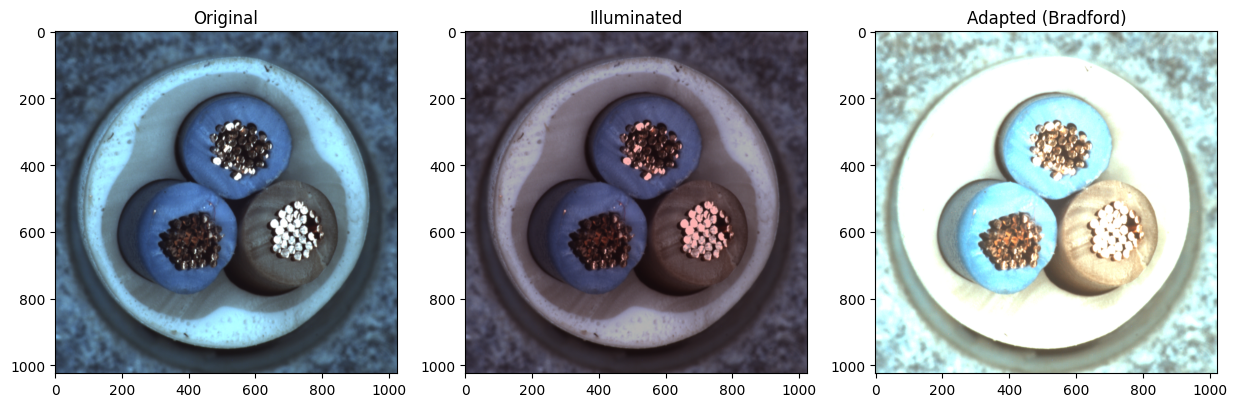

In [10]:
image = plt.imread('001.png')

# Simulate different illumination (e.g., reddish tint for demonstration)
illuminated = image * np.array([1.0, 0.7, 0.7])  # Apply tint, clip if needed
illuminated = np.clip(illuminated, 0, 1)

# Source white point (estimated from illuminated, e.g., average)
src_wp = np.mean(illuminated, axis=(0,1))

# Destination white point (neutral)
dst_wp = np.array([1.0, 1.0, 1.0])

# Apply Bradford CAT
adapted = chromatic_adaptation_image(src_wp, dst_wp, illuminated, cat_type='BRADFORD')

# Display to demonstrate constancy (adapted should look closer to original)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image)
axs[0].set_title('Original')
axs[1].imshow(illuminated)
axs[1].set_title('Illuminated')
axs[2].imshow(adapted)
axs[2].set_title('Adapted (Bradford)')
plt.show()